# GSK CODE CHALLENGE

## Problem Statement
A new cancer treatment for solid tumours (Miraculon-B) is in development at GSK, data has been collected in our recent clinical trial comparing Miraculon-B to the current standard of care (i.e., referred to as the ‘control’). The trial has completed, and we need your help to analyse the data and assess the effectiveness of Miraculon-B. To do this we need you to compare Miraculon-B to the standard of care, and explore how different patient sub-groups may benefit differently from treatment.

## Importing Relevant Libraries

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

## Preprocessing the protein level dataset

In [2]:
# Reading the protein levels data
protein_data = pd.read_csv("protein-levels.csv")

In [3]:
# Checking the data dimension of the protein dataset
protein_data.shape

(768, 2)

- The protein dataset contains 769 rows and 8 columns

In [4]:
# Displaying the first 5 rows of the protein level dataset
protein_data.head()

,participant_id,protein_concentration
0,SUBJ_001,148.0
1,SUBJ_002,85.0
2,SUBJ_003,183.0
3,SUBJ_004,89.0
4,SUBJ_005,137.0


In [5]:
# Checking for duplicate data in the protein dataset
protein_data.duplicated().sum()

0

- No duplicate data was found in the protein dataset

## Preprocessing the clinical dataset

In [6]:
# Reading the clinical study data
clinical_data = pd.read_csv("clinical-study.csv")

In [7]:
# Checking the data dimension of the clinical dataset
clinical_data.shape

(772, 7)

- The clinical dataset contains 772 rows and 7 columns

In [8]:
# Displaying the first 5 rows of the clinical dataset
clinical_data.head()

,subject_id,age,sex,weight,height,trt_grp,RESPONSE
0,SUBJ_001,46.0,Female,84.66,1.59,DRUG,N
1,SUBJ_001,46.0,Female,84.66,1.59,DRUG,N
2,SUBJ_002,47.0,Female,71.21,1.64,DRUG,Y
3,SUBJ_003,48.0,Female,69.85,1.73,CONTROL,N
4,SUBJ_004,59.0,Female,62.94,1.50,DRUG,Y


- Given that the "subject_id" column in the clinical dataset and the "participant_id" column in the protein level dataset contain similar values, it is necessary to rename the "subject_id" column heading to "participant_id".

In [9]:
# Rename the column heading
clinical_data = clinical_data.rename(columns={"subject_id": "participant_id"})

In [10]:
# Sanity Check
clinical_data.head()

,participant_id,age,sex,weight,height,trt_grp,RESPONSE
0,SUBJ_001,46.0,Female,84.66,1.59,DRUG,N
1,SUBJ_001,46.0,Female,84.66,1.59,DRUG,N
2,SUBJ_002,47.0,Female,71.21,1.64,DRUG,Y
3,SUBJ_003,48.0,Female,69.85,1.73,CONTROL,N
4,SUBJ_004,59.0,Female,62.94,1.50,DRUG,Y


- From the result above, it can be observed that the column heading "subject_id" has been successfully renamed to "participant_id". This renaming will facilitate the merging of the two tables. Additionally, by examining the first five rows of the dataset, it becomes apparent that duplicates exist within the data. Further investigation into these duplicates will be conducted in the subsequent cells.

In [11]:
# Checking for duplicate data in the clinical dataset
clinical_data.duplicated().sum()

1

- One (1) duplicate data was found in the dataset.

In [12]:
# Dropping the duplicate row and resetting the index
clinical_data = clinical_data.drop_duplicates().reset_index(drop=True)

In [13]:
# Sanity check
clinical_data.duplicated().sum()

0

- It's clear that the duplicate data has been dropped.

In [14]:
# Checking if there is any paediatric data in the dataset
clinical_data[clinical_data["age"] < 18]

,participant_id,age,sex,weight,height,trt_grp,RESPONSE
768,SUBJ_A69,7.200,Female,22.310,1.19300,DRUG,N
769,SUBJ_A70,8.310,Female,24.220,1.27440,CONTROL,N
770,SUBJ_A71,7.854,Male,23.176,1.26343,CONTROL,N


- It's clear from the result above that there are 3 records of paediatric patients present in the clinical dataset and will be expunged in the following cell.

In [15]:
# Finding the rows where age is less than 18
rows_to_drop = clinical_data[clinical_data["age"] < 18].index

# Dropping the rows from the DataFrame
clinical_data.drop(rows_to_drop, inplace=True)

In [16]:
# Sanity check
clinical_data[clinical_data["age"] < 18]

,participant_id,age,sex,weight,height,trt_grp,RESPONSE


- The result above shows that the rows where age is less than 18 have been dropped.

In [17]:
# Checking the new shape of the clinical data
clinical_data.shape

(768, 7)

- It's evident from the result above that the clinical data and protein level data now have the same number of rows and are  ready for merging.

## Merging the clinical and protein datasets

In [18]:
# Merging the two datasets on the "participant_id" column
merged_data = pd.merge(clinical_data, protein_data, on="participant_id")

# Rename the merged column as "patient_id"
merged_data = merged_data.rename(columns={"participant_id": "patient_id"})

In [19]:
# Showing the data dimension of the merged data
merged_data.shape

(768, 8)

- The dataset contains 768 rows and 8 columns

In [20]:
# Showing the first 5 rows of the merged dataset
merged_data.head()

,patient_id,age,sex,weight,height,trt_grp,RESPONSE,protein_concentration
0,SUBJ_001,46.0,Female,84.66,1.59,DRUG,N,148.0
1,SUBJ_002,47.0,Female,71.21,1.64,DRUG,Y,85.0
2,SUBJ_003,48.0,Female,69.85,1.73,CONTROL,N,183.0
3,SUBJ_004,59.0,Female,62.94,1.50,DRUG,Y,89.0
4,SUBJ_005,59.0,Female,113.91,1.63,CONTROL,N,137.0


- The two clinical dataset and protein dataset have been successfully merged.

## Handling Missing Values

In [21]:
# Checking the missing values
merged_data.isnull().sum()

patient_id                0
age                       0
sex                       0
weight                   11
height                    0
trt_grp                   0
RESPONSE                  0
protein_concentration     5
dtype: int64

- This result above shows that there are 11 missing values in the weight variables and 5 missing values in the protein_concentration variable. This will be further investigated in the following cell.

In [22]:
# Finding the rows with missing values
rows_with_missing_values = merged_data[merged_data.isnull().any(axis=1)]

# Displaying the rows with missing values
rows_with_missing_values

,patient_id,age,sex,weight,height,trt_grp,RESPONSE,protein_concentration
9,SUBJ_010,73.0,Female,NaN,1.64,DRUG,Y,125.0
49,SUBJ_050,65.0,Male,NaN,1.71,DRUG,N,105.0
60,SUBJ_061,61.0,Male,NaN,1.79,CONTROL,N,84.0
75,SUBJ_076,78.0,Male,78.92,1.79,DRUG,N,NaN
81,SUBJ_082,65.0,Male,NaN,1.78,CONTROL,N,74.0
145,SUBJ_146,56.0,Female,NaN,1.57,CONTROL,N,102.0
182,SUBJ_183,56.0,Male,91.92,1.83,DRUG,N,NaN
342,SUBJ_343,70.0,Male,92.01,1.70,DRUG,N,NaN
349,SUBJ_350,51.0,Male,118.81,1.71,DRUG,Y,NaN
371,SUBJ_372,67.0,Female,NaN,1.62,CONTROL,N,118.0


- As the missing values cannot be imputed solely based on other variables, alternative statistical methods will be utilized to fill in the missing values.

In [23]:
# Filling in missing values in the weight variable with the mean value
merged_data['weight'].fillna(merged_data['weight'].mean(), inplace=True)

In [24]:
# Filling in missing values in the weight variable with the median value
merged_data['protein_concentration'].fillna(merged_data['protein_concentration'].median(), inplace=True)

In [25]:
# Sanity check
merged_data.isnull().sum()

patient_id               0
age                      0
sex                      0
weight                   0
height                   0
trt_grp                  0
RESPONSE                 0
protein_concentration    0
dtype: int64

- It's evident from the result above that the missing values have been filled.

In [26]:
# Checking some information about the dataset
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             768 non-null    object 
 1   age                    768 non-null    float64
 2   sex                    768 non-null    object 
 3   weight                 768 non-null    float64
 4   height                 768 non-null    float64
 5   trt_grp                768 non-null    object 
 6   RESPONSE               768 non-null    object 
 7   protein_concentration  768 non-null    float64
dtypes: float64(4), object(4)
memory usage: 54.0+ KB


- All the variables have the right data types.

## Feature Engineering
A new column will be added to the data for the BMI of the patients. 
BMI is calculated by dividing weight by the square of height.

In [27]:
# Calculating the BMI (Body Mass Index)
merged_data['bmi'] = merged_data['weight'] / ((merged_data['height']) ** 2)

# Rounding the 'bmi' variable to two decimal places
merged_data['bmi'] = merged_data['bmi'].round(2)

In [28]:
# Displaying the new dataframe having the bmi variable
merged_data.head()

,patient_id,age,sex,weight,height,trt_grp,RESPONSE,protein_concentration,bmi
0,SUBJ_001,46.0,Female,84.66,1.59,DRUG,N,148.0,33.49
1,SUBJ_002,47.0,Female,71.21,1.64,DRUG,Y,85.0,26.48
2,SUBJ_003,48.0,Female,69.85,1.73,CONTROL,N,183.0,23.34
3,SUBJ_004,59.0,Female,62.94,1.50,DRUG,Y,89.0,27.97
4,SUBJ_005,59.0,Female,113.91,1.63,CONTROL,N,137.0,42.87


In [29]:
# Checking the data description
merged_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,768.0,61.811198,7.107447,37.00,57.0000,62.000,67.00,79.00
weight,768.0,91.387583,21.977525,46.17,75.9325,89.150,104.40,182.50
height,768.0,1.679271,0.097888,1.42,1.6000,1.680,1.76,1.94
protein_concentration,768.0,121.656250,30.438286,44.00,99.7500,117.000,140.25,199.00
bmi,768.0,32.317005,6.877249,17.98,27.3650,32.085,36.35,67.52


The summary of the statistics for the variables in the dataset are:

- Age: The dataset has an average age of approximately 61.81. The observed ages range from a minimum of 37 to a maximum of 79. The 25th percentile falls below 57, indicating that 25% of the data is below this age. The median age is 62, with 50% of the data falling below this value. The 75th percentile is 67, indicating that 75% of the data is below this age.

- Weight: The average weight in the dataset is approximately 91.39. The minimum weight observed is 46.17, while the maximum weight is 182.50. The 25th percentile falls below 75.93, meaning that 25% of the data is below this weight. The median weight is 89.15, with 50% of the data falling below this value. The 75th percentile is 104.40, indicating that 75% of the data is below this weight.

- Height: The average height is approximately 1.68. The minimum height observed is 1.42, while the maximum height is 1.94. The 25th percentile falls below 1.60, indicating that 25% of the data is below this height. The median height is 1.68, with 50% of the data falling below this value. The 75th percentile is 1.76, meaning that 75% of the data is below this height.

- Protein Concentration: The average protein concentration is approximately 121.66. The minimum concentration observed is 44.00, while the maximum concentration is 199.00. The 25th percentile falls below 99.75, indicating that 25% of the data is below this concentration. The median protein concentration is 117.00, with 50% of the data falling below this value. The 75th percentile is 140.25, meaning that 75% of the data is below this concentration.

- BMI: The average BMI is approximately 32.32. The minimum BMI observed is 17.98, while the maximum BMI is 67.52. The 25th percentile falls below 27.36, indicating that 25% of the data is below this BMI. The median BMI is 32.09, with 50% of the data falling below this value. The 75th percentile is 36.35, meaning that 75% of the data is below this BMI.

## Aggregating the data

In [33]:
# Comparing mean age in the two treatment groups
merged_data["age"].groupby(merged_data["trt_grp"]).mean()

trt_grp
CONTROL    61.862338
DRUG       61.759791
Name: age, dtype: float64

- The analysis reveals that control treatment exhibit a higher mean age (61.86) compared to drug treatment, where the mean age is slightly lower (61.76).

In [34]:
# Comparing mean age in responders vs non-responders
merged_data["age"].groupby(merged_data["RESPONSE"]).mean()

RESPONSE
N    61.748848
Y    61.892216
Name: age, dtype: float64

- The analysis reveals that responders exhibit a higher mean age (61.89) compared to non-responders, where the mean age is slightly lower (61.75).

In [38]:
# Comparing responders and non-responders in the two treatment arms
response_by_treatment = merged_data.groupby(["trt_grp", "RESPONSE"]).size().unstack()

# Print the comparison
response_by_treatment

RESPONSE,N,Y
trt_grp,,
CONTROL,261,124
DRUG,173,210


- The analysis indicates that a higher number of patients responded to the drug treatment compared to the control treatment. Conversely, the control treatment had a larger population of non-responders than the drug treatment. These findings suggest that the new cancer treatment for solid tumors, known as Miraculon-B, demonstrates greater effectiveness than the current standard of care (referred to as the 'control').

In [39]:
# Comparing mean weight in responders vs non-responders
merged_data["weight"].groupby(merged_data["RESPONSE"]).mean()

RESPONSE
N    89.953544
Y    93.250974
Name: weight, dtype: float64

- The analysis reveals that responders exhibit a higher mean weight (93.25) compared to non-responders, where the mean weight is lower (89.95).

In [43]:
# Comparing mean protein concentration in responders vs non-responders
merged_data["protein_concentration"].groupby(merged_data["RESPONSE"]).mean()

RESPONSE
N    134.852535
Y    104.508982
Name: protein_concentration, dtype: float64

- The analysis reveals that responders exhibit a lower mean protein concentration (104.51) compared to non-responders, where the mean protein concentration is higher (134.85). This predicts that patients with an average protein concentration of 134.9 may not respond to treatment. It also confirms that assumption that protein concentration is a potential predictive biomarker for solid tumours.

In [51]:
# Comparing sex in responders and non-responders under the two treatment arms
response_by_treatment = merged_data.groupby(["sex", "RESPONSE", "trt_grp"]).size().unstack()

# Print the comparison
response_by_treatment

trt_grp          CONTROL  DRUG
sex    RESPONSE               
Female N             136    84
       Y              66   103
Male   N             125    89
       Y              58   107

- The analysis reveals that a greater proportion of male patients responded to the drug treatment compared to female patients, albeit with a slightly lower number of responders. However, a greater proportion of female patients responded to the control treatment compared to male patients.

In [52]:
# Comparing mean BMI in responders vs non-responders
merged_data["bmi"].groupby(merged_data["RESPONSE"]).mean()

RESPONSE
N    31.855138
Y    32.917156
Name: bmi, dtype: float64

- The analysis suggests that patients with higher average bmi responded to treatment compared to patients with lower average bmi who did not respond to treatment.

## Visualisation

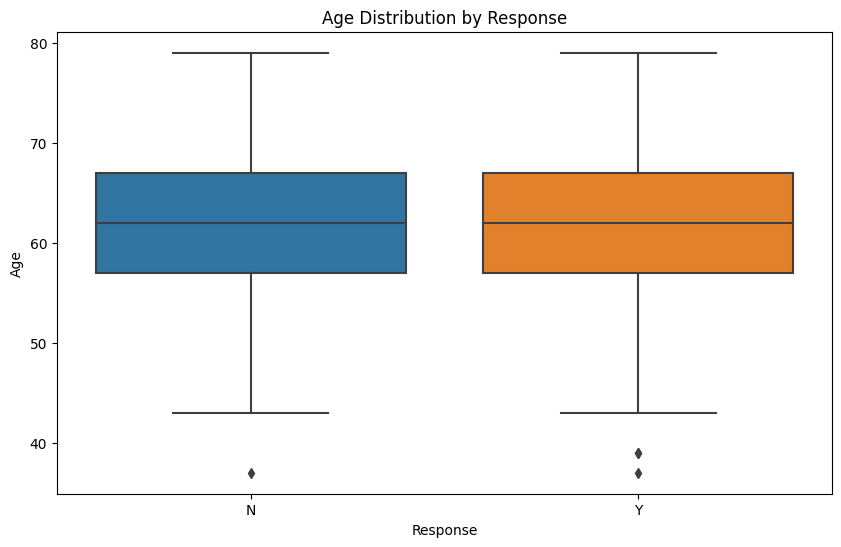

In [56]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x="RESPONSE", y="age", data=merged_data)

# Add labels and title
plt.xlabel("Response")
plt.ylabel("Age")
plt.title("Age Distribution by Response")

# Display the plot
plt.show()

- The plot suggests that the average age of both the responders and non-responders for the two arms of treatment is 62.

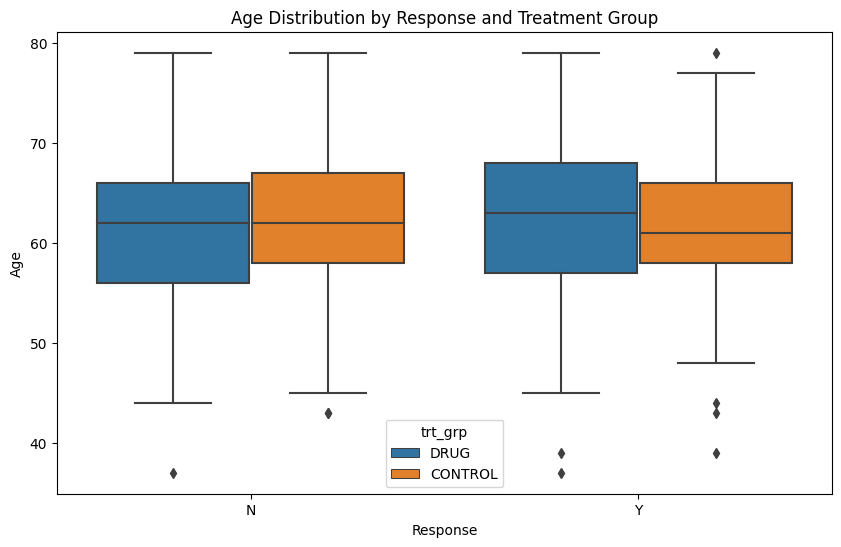

In [57]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x="RESPONSE", y="age", hue = "trt_grp", data=merged_data)

# Add labels and title
plt.xlabel("Response")
plt.ylabel("Age")
plt.title("Age Distribution by Response and Treatment Group")

# Display the plot
plt.show()

- The plot suggests that the average age of both the responders and non-responders for the two arms of treatment is 62.

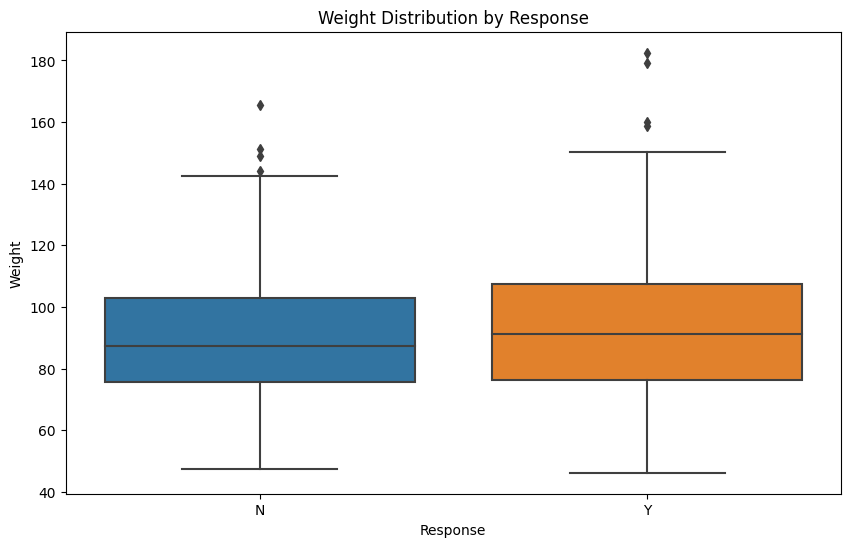

In [58]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x="RESPONSE", y="weight", data=merged_data)

# Add labels and title
plt.xlabel("Response")
plt.ylabel("Weight")
plt.title("Weight Distribution by Response")

# Display the plot
plt.show()

- The plot above suggests that the average weight of both responders and non-responders is 85

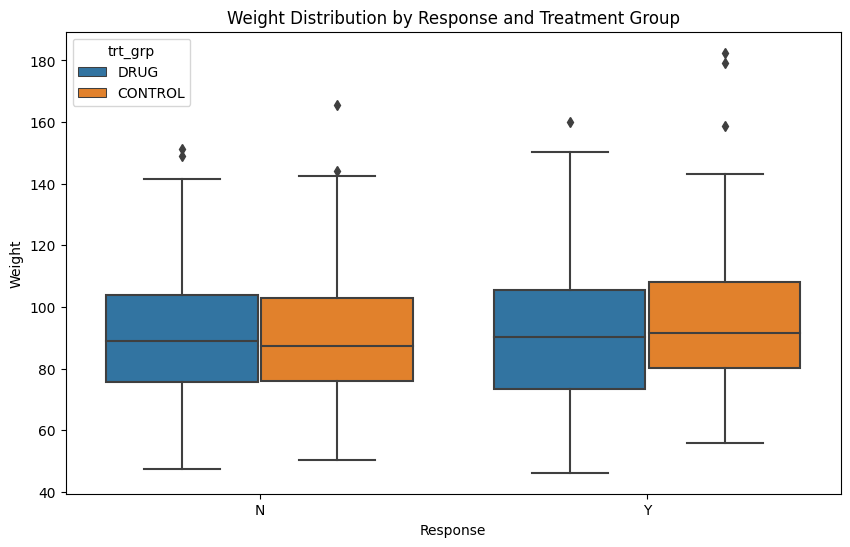

In [59]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x="RESPONSE", y="weight", hue = "trt_grp", data=merged_data)

# Add labels and title
plt.xlabel("Response")
plt.ylabel("Weight")
plt.title("Weight Distribution by Response and Treatment Group")

# Display the plot
plt.show()

- The plot above suggests that the average weight of both responders and non-responders is 85 for both control treatment and drug treatment groups.

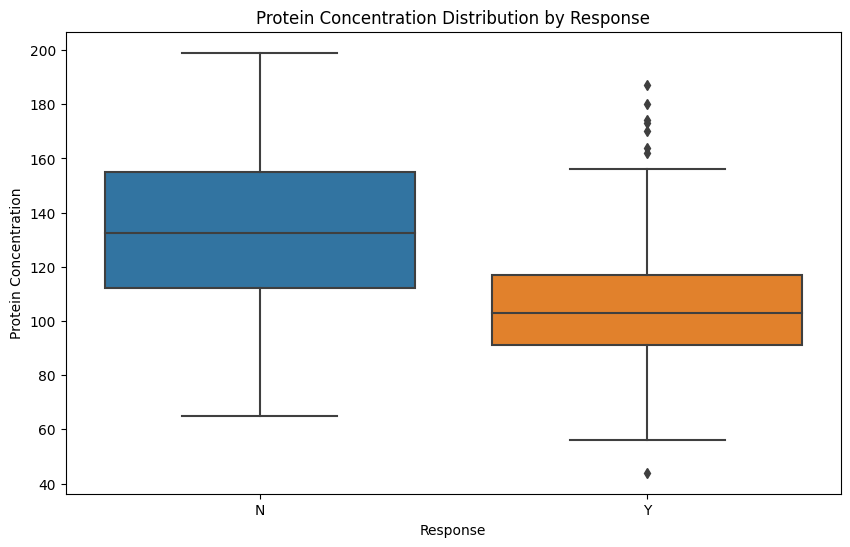

In [61]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x="RESPONSE", y="protein_concentration", data=merged_data)

# Add labels and title
plt.xlabel("Response")
plt.ylabel("Protein Concentration")
plt.title("Protein Concentration Distribution by Response")

# Display the plot
plt.show()

- The plot above suggests that patients with low protein concentration responded more to control treatment and drug treatment than patients with high protein concentration.

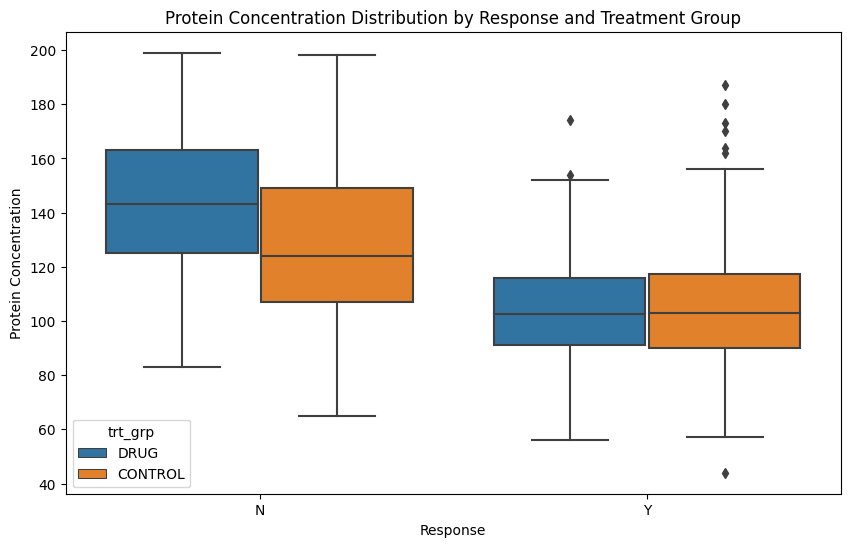

In [60]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x="RESPONSE", y="protein_concentration", hue = "trt_grp", data=merged_data)

# Add labels and title
plt.xlabel("Response")
plt.ylabel("Protein Concentration")
plt.title("Protein Concentration Distribution by Response and Treatment Group")

# Display the plot
plt.show()

- The plot above suggests that patients with low protein concentration responded more to control treatment and drug treatment than patients with high protein concentration.

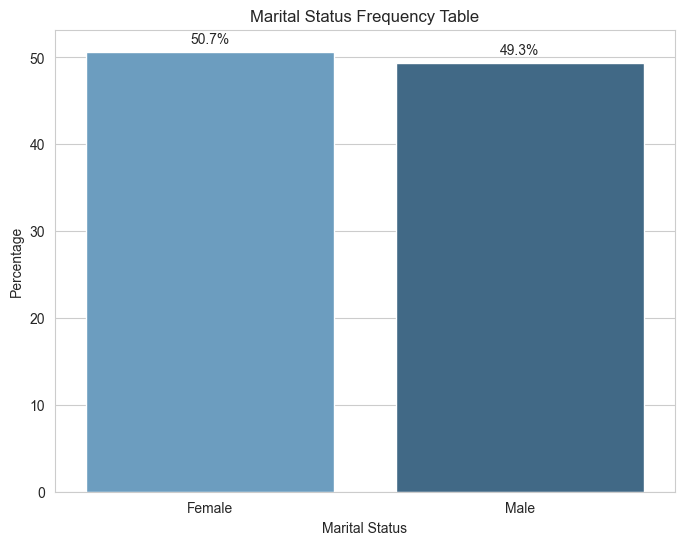

In [66]:
# Calculate count and percentage of each marital status
count = merged_data['sex'].value_counts()
percent = count / len(merged_data) * 100

# Create a table-like plot of marital status counts and percentages
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))
plt.savefig("Marital_Freqplot.png")
ax = sns.barplot(x=count.index, y=percent, palette="Blues_d")
ax.set(xlabel='Marital Status', ylabel='Percentage', title='Marital Status Frequency Table')

# Add percentage labels above each bar
for i, v in enumerate(percent):
    ax.text(i,  v+1, f"{v:.1f}%", ha='center', fontsize=10)

plt.show()

- The plot above shows that more female patients went through the clinical trials compared to the male patients.

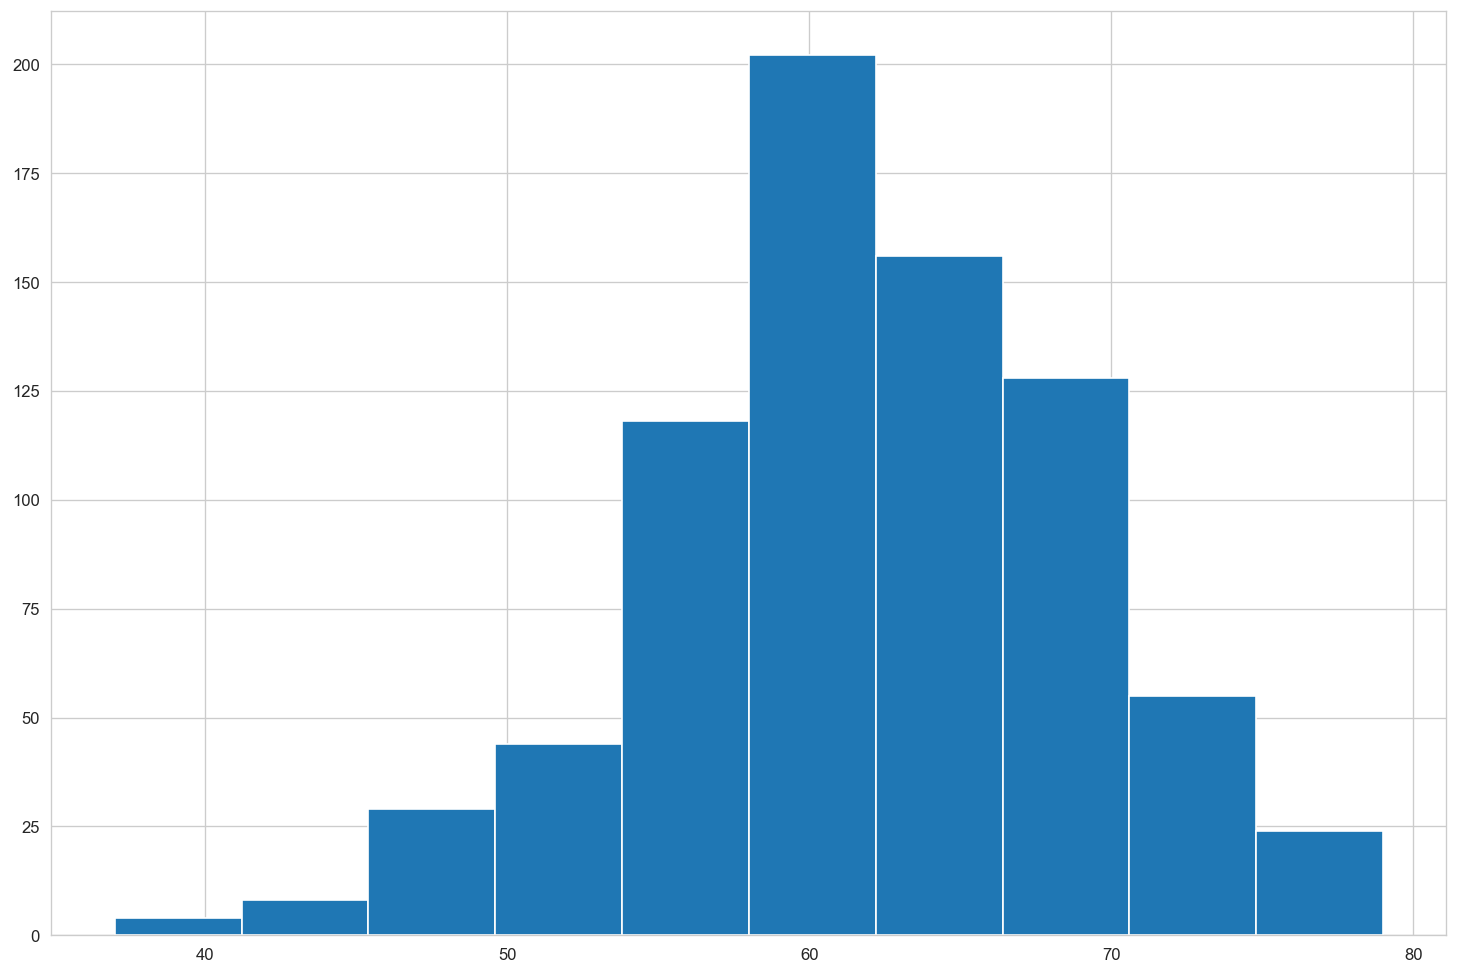

In [67]:
# Checking the age distribution
plt.figure(dpi = 120);
merged_data["age"].hist(figsize = (15, 10));
plt.show();

- The plot above shows the age distribution of the patients that went through the clinical trials.

C:\Users\SPESSE ENVIROMENT\AppData\Local\Temp\ipykernel_46920\3020406650.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = merged_data.corr()


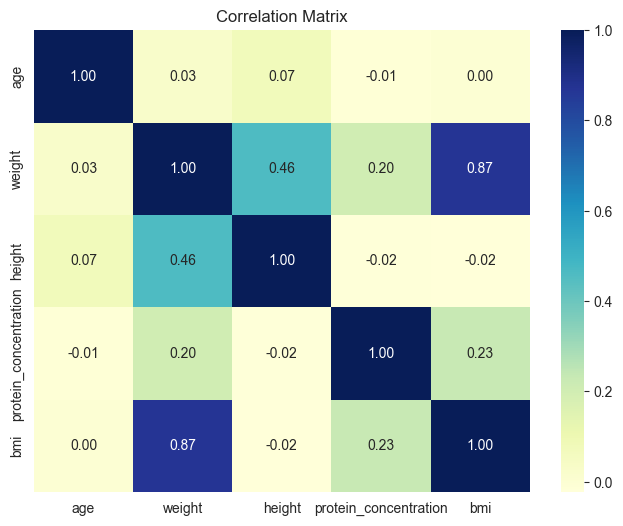

In [74]:
# Correlation matrix
correlation_matrix = merged_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt = '.2f')
plt.title("Correlation Matrix")
plt.show()

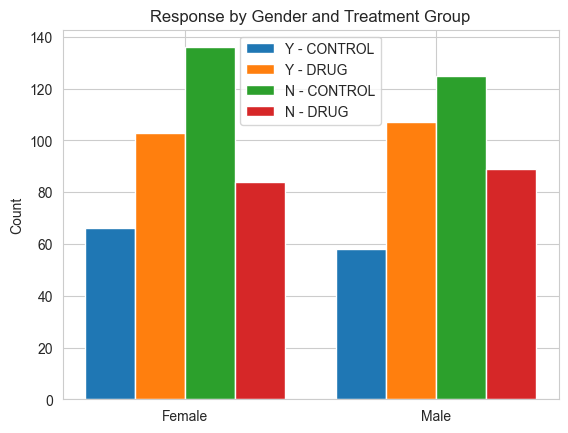

In [69]:
import matplotlib.pyplot as plt

# Sample data
gender = merged_data["sex"]
response = merged_data["RESPONSE"]
trt_grp = merged_data["trt_grp"]

# Count the occurrences of each combination of categories
data = {}
for g, r, t in zip(gender, response, trt_grp):
    if g not in data:
        data[g] = {}
    if r not in data[g]:
        data[g][r] = {}
    if t not in data[g][r]:
        data[g][r][t] = 0
    data[g][r][t] += 1

# Extract categories and counts
categories = list(data.keys())
response_categories = list(set(response))
trt_grp_categories = list(set(trt_grp))
counts = [[[data[g].get(r, {}).get(t, 0) for t in trt_grp_categories] for r in response_categories] for g in categories]

# Plotting
x = range(len(categories))
width = 0.2

fig, ax = plt.subplots()
rects = []
for i in range(len(response_categories)):
    for j in range(len(trt_grp_categories)):
        rect = ax.bar([xval + (i * len(trt_grp_categories) + j) * width for xval in x], [count[i][j] for count in counts], width, label=response_categories[i] + ' - ' + trt_grp_categories[j])
        rects.append(rect)

# Set x-axis labels and ticks
ax.set_xticks([xval + ((len(response_categories) * len(trt_grp_categories) - 1) / 2) * width for xval in x])
ax.set_xticklabels(categories)

# Set y-axis label
ax.set_ylabel('Count')

# Set chart title
ax.set_title('Response by Gender and Treatment Group')

# Set legend
ax.legend(rects, [response + ' - ' + trt_grp for response in response_categories for trt_grp in trt_grp_categories])

# Display the chart
plt.show()

- The plot above suggests that the female patients responded more to the control treatment than the male patients while the male patients responded more to the drug treatment than the female patients.

## Logistic Regression

### Splitting the dataset

In [76]:
merged_data.columns

Index(['patient_id', 'age', 'sex', 'weight', 'height', 'trt_grp', 'RESPONSE',
       'protein_concentration', 'bmi'],
      dtype='object')

In [80]:
# Select the relevant features for logistic regression
features = ['age', 'sex', 'weight', 'height', 'trt_grp', 'protein_concentration', 'bmi']
target = 'RESPONSE'
X = merged_data[features]
y = merged_data[target]

# Convert categorical variables to numerical using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the numerical features
scaler = StandardScaler()
numerical_features = ['age', 'weight', 'height', 'protein_concentration', 'bmi']
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


Accuracy: 0.7987012987012987


## Random Forest

In [81]:
# Train the Random Forest classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

<IPython.core.display.Javascript object>

Accuracy: 0.7662337662337663
